In [5]:
import cPickle as cp

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import bivariate_normal

import autograd.numpy as np
from autograd import grad
%matplotlib inline

In [6]:
dim = 2
plot_x_lim = [-6, 6]
plot_y_lim = [-40, 10]
x = np.arange(plot_x_lim[0], plot_x_lim[1], 0.5)
y = np.arange(plot_y_lim[0], plot_y_lim[1], 0.5)
X, Y = np.meshgrid(x, y)

Let's define a function to perform AdaM updates...

In [7]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

### Learning Model Reparametrizations
#### By Michalis K. Titsias

The idea behind [Learning Model Reparametrizations](https://arxiv.org/abs/1708.01529) is to parametrize a transformation involving the variable of interest and samples from a fixed distribution: $$ \boldsymbol{\theta} = g(\boldsymbol{\xi}; \boldsymbol{\phi}), \ \boldsymbol{\xi} \sim p_{0} $$ where $\boldsymbol{\theta}$ is the model variable, $\boldsymbol{\phi}$ are the transformation parameters, and $p_{0}$ the fixed distribution.  Then MCMC can be run to collect $\boldsymbol{\xi}$ samples, which, ostensibly, is easier than collecting samples of $\boldsymbol{\theta}$ directly.

### Experiment: Collecting samples from the banana distribution
Let's draw data from the classic MCMC test case: the banana distribution...

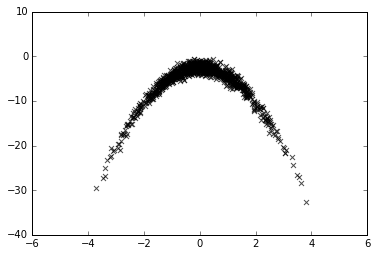

In [8]:
### Make Dataset
N = 1000
data = np.random.normal(size=(N, dim))
z1 = 1.25*data[:,0]
z2 = data[:,1]/1.25 - 2*(z1**2 + 1.25)
data = np.hstack([z1[np.newaxis].T, z2[np.newaxis].T])
np.random.shuffle(data)

plt.scatter(data[:,0], data[:,1], marker='x', s=25, c='k', alpha=.7)

plt.xlim([plot_x_lim[0], plot_x_lim[1]])
plt.ylim([plot_y_lim[0], plot_y_lim[1]])
plt.show()

### Method

Let's define the necessary primatives...

In [ ]:
def run_MH(data, unNorm_model, reparam_params, proposal, e0, n_MCMC_its):
    samples = []
    theta0 = reparam_params['mu'] + np.dot(reparam_params['L'], e0)
    
    for idx in range(n_MCMC_its):
        proposal = np.random.normal(loc=e0, size=(1,2))
        theta = reparam_params['mu'] + np.dot(reparam_params['L'], proposal)
        
        ratio = unNorm_model(data, theta) / unNorm_model(data, theta0) 
        correction = gaussPdf(e0, {'mu':proposal, 'sigma':1.}) / gaussPdf(proposal, {'mu':e0, 'sigma':1.})
        
        accept_prob = np.minimum(1., ratio * correction)
        uni_prob = np.random.uniform(low=0., high=1.)
        
        if uni_prob <= accept_prob:
            samples.append(proposal)
            e0 = proposal
            theta0 = reparam_params['mu'] + np.dot(reparam_params['L'], e0)
            
    return samples

In [ ]:
def run_implicitMCMC_VI(data, model_params, reparam_params, lr=.001, n_epochs=100, n_MCMC_its=100):
    
    adam_values = [{'mu':{'mean': 0., 'var': 0., 't': 0}, 
                    'logL':{'mean': 0., 'var': 0., 't': 0},
                    'logSigma':{'mean': 0., 'var': 0., 't': 0},
                   }]
    
    for it_idx in range(n_iterations):
        
        # update the reparametrization parameters
        e0 = np.random.normal(size=(1,2))
        e_samples = run_MH(data, modelWithTransform, reparam_params, proposal, e0, n_MCMC_its)
        
        grad_mu = 0.
        grad_logL = 0.
        for e in e_samples:
            grad_mu += dLogModelWithTransform_dMu(reparam_params['mu'], data, model_params['logSigma'], e)
            grad_logL += dLogModelWithTransform_dL(reparam_params['logL'], data, model_params['logSigma'], e)
        
        reparam_params['mu'] += get_AdaM_update(lr, grad/len(e_samples), adam_values['mu'])
        reparam_params['logL'] += get_AdaM_update(lr, grad/len(e_samples), adam_values['logL'])
        
        # update model params
        e0 = np.random.normal(size=(1,2))
        e_samples = run_MH(data, unNorm_model, reparam_params, proposal, e0, n_MCMC_its)
        thetas = [reparam_params['mu'] + np.dot(e, np.exp(reparam_params['logL'])) for e in e_samples]
        
        grad = 0.
        for theta in thetas:
            grad += dLogModel_dLogSigma(model_params['logSigma'], data, theta)
        
        model_params['logSigma'] += get_AdaM_update(lr, grad/len(thetas), adam_values['logSigma'])

    # get one more round of samples
    final_e_samples = run_MH(data, modelWithTransform, reparam_params, proposal, e0, n_MCMC_its)
    
    return model_params, reparam_params, final_e_samples

In [ ]:
# Gaussian
def gaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

# Gaussian model
def logModel(data, theta, logSigma):
    return np.sum(np.log(gaussPdf(data, {'mu':theta, 'sigma': np.exp(logSigma)})))

# Gaussian model with lower triangular inv transform
def logModel_w_transform(data, mu, logL, e, logSigma):
    L = np.exp(logL)
    theta = mu + np.dot(e, L)
    return logModel(data, theta, logSigma) - np.sum(np.log(np.diagonal(L)))

In [ ]:
dLogModelWithTransform_dMu = grad(lambda mu, data, logL, e, sigma: logModel_w_transform(data, mu, logL, e, sigma))

dLogModelWithTransform_dLogL = grad(lambda logL, data, mu, e, sigma: logModel_w_transform(data, mu, logL, e, sigma))

dLogModel_dLogSigma = grad(lambda logSigma, data, theta: logModel(data, theta, logSigma))

In [ ]:
# Set training params
n_epochs = 500
learning_rate = .1



In [ ]:
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=final_params['sigma'][0,0], sigmay=final_params['sigma'][0,1], mux=final_params['mu'][0,0], muy=final_params['mu'][0,1], sigmaxy=0.)
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()